## Goal of Experiment 1: Set aside a testing set that contains equal amounts of normal and abnormal subset. Use the rest of data for training and use custom loss to scale based on training ratio of normal to abnormal subsets.

In [1]:
import pandas as pd
import seaborn as sns
import cv2
import numpy as np

from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

import tensorflow as tf
# import tensorflow.compat.v1 as tf
from tensorflow import keras
from tensorflow.keras.layers import Lambda
from keras.preprocessing.sequence import pad_sequences
import os, sys, time
from math import floor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from collections import OrderedDict
# from tensorflow.python.ops import math_ops
# import tensorflow.keras.backend as kb
from tensorflow_addons.utils.ensure_tf_install import _check_tf_version
_check_tf_version()
from tensorflow_addons import losses
# Custom Functions
# Added to path by using sys.path.append('')
sys.path.append('/home/akanu/git/anomalous_pred/custom_functions')
from load_data import Files_Load, Boxes, test_split_norm_abnorm, norm_train_max_min
from custom_metrics import bb_intersection_over_union, bb_intersection_over_union_np
from coordinate_change import xywh_tlbr, tlbr_xywh
from pedsort import pedsort
from load_data_binary_class import return_indices, binary_data_split, same_ratio_split_train_val


# Kmeans
from sklearn.cluster import KMeans

# Need to figue out why this is not working
# from persistence1d import RunPersistence


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
plt.style.use('classic')

# GPU check

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  2


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


# Load Data

In [7]:
frames = 20

# train_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Train_Box/"
# test_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/"

train_file = "/home/akanu/dataset/dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Train_Box/"
test_file = "/home/akanu/dataset/dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/"

loc_files_train, loc_files_test, box_train_txt, box_test_txt = Files_Load(train_file, test_file)

# Don't forget to change to xywh 
traindict = Boxes(loc_files_train, box_train_txt, frames, pad ='pre', to_xywh=True)
testdict = Boxes(loc_files_test, box_test_txt, frames, pad ='pre', to_xywh = True)
abnormal_dict, normal_dict = test_split_norm_abnorm(testdict) #splits by which predicted frames are normal or not

# Normilize data
max1 = traindict['x_ppl_box'].max()
min1 = traindict['x_ppl_box'].min()
xx,yy = norm_train_max_min(data_dict = traindict, max1=max1,min1=min1)
xx_norm,yy_norm = norm_train_max_min(data_dict = normal_dict, max1=max1,min1=min1)
xx_abnorm,yy_abnorm = norm_train_max_min(data_dict = abnormal_dict, max1=max1,min1=min1)


In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
xx_train, xx_val,yy_train,yy_val = train_test_split(xx,yy, test_size = 0.3)
train_univariate = tf.data.Dataset.from_tensor_slices((xx_train,yy_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_univariate = tf.data.Dataset.from_tensor_slices((xx_val,yy_val))
val_univariate = val_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Load or Train Model

In [10]:
# sys.path.insert(0,'/home/akanu/git/anomalous_pred/model')
sys.path.insert(0,'/home/akanu/project/anomalous_pred/model')
from lstm_models import lstm_xywh_avenue_20

In [11]:
# model_loc = '/home/akanu/git/anomalous_pred/saved_models'
model_loc = '/home/akanu/project/anomalous_pred/saved_models'
nc=['lstm', 'xywh', 'avenue', frames]


In [12]:
loaded_model = os.path.join(model_loc,
                            '{}_{}_{}_{}.h5'.format(nc[0], nc[1],nc[2], nc[3]))
lstm_20 = tf.keras.models.load_model(loaded_model,  
                                   custom_objects = {'loss':'mse'} , 
                                   compile=True)


# Load Data for Binary Network

# Checking index values are correct
# 1) Size
# 2) Correct Selection

In [13]:

indices = return_indices(testdict['abnormal'], abnormal_split = 0.5, seed=24)


In [14]:
indices[1][:10]

array([  3033, 112454, 112478,  55144,  44970,  17184,  48588,  54341,
        39439,  54753])

In [15]:
print('These are index\n' + 
       'train_abn:{},train_n: {},test_abn: {},test_n {}'.format(indices[0].shape,
                                                                indices[1].shape,
                                                                indices[2].shape,
                                                                indices[3].shape,))

These are index
train_abn:(1465,),train_n: (111229,),test_abn: (1465,),test_n (1465,)


# 2) Correct Selection

In [16]:
print('Are abnormal values for train and test respectively correct? \n' +
     '{} and {}'.format(np.all(testdict['abnormal'][indices[0]] == 1),
                        np.all(testdict['abnormal'][indices[2]] ==1)
                       )
     )

Are abnormal values for train and test respectively correct? 
True and True


In [17]:
print('Are normal values for train and test respectively correct? \n' +
     '{} and {}'.format(np.all(testdict['abnormal'][indices[1]] == 0),
                        np.all(testdict['abnormal'][indices[3]] ==0)
                       )
     )

Are normal values for train and test respectively correct? 
True and True


In [39]:
x,y = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )
print('x has a shape of : {}\n'.format(x.shape) +
      'y has a shape of : {}'.format(y.shape))

x has a shape of : (115624, 20, 4)
y has a shape of : (115624, 4)


In [40]:
x.max()

1.1203043271516882

COuld probably make binary data split easier for adding more features
by performing data auc outside and inputing that into function. Might look into as well to make code more maintainable. Could allow me to call the function in some ratio split train val function.

In [19]:
train_full_x,train_full_y, test_x, test_y = binary_data_split(x,y,lstm_20, indices)

In [20]:
print('Comparing shape length of train_full_x and test_x \n' +
     'train_full_x: {}, test_x:{}'.format(train_full_x.shape,
                                         test_x.shape))

Comparing shape length of train_full_x and test_x 
train_full_x: (2, 112694), test_x:(2, 2930)


In [22]:
val_x, val_y, train_x, train_y = same_ratio_split_train_val(train_full_x,train_full_y, val_ratio = 0.3)
weight_ratio = len(indices[0])/len(indices[1])


In [36]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
# Note that I need to index into correct column as one is IOU
# The reason why this returns IOU is because of binary_data_-split function
# and last column is index values to map back into datadict
train_bm = tf.data.Dataset.from_tensor_slices((train_x[0,:],train_y))
train_bm = train_bm.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_bm = tf.data.Dataset.from_tensor_slices((val_x[0,:],val_y))
val_bm = val_bm.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [38]:
train_x[0,:].min()

0.0

# Weighted Loss

In [30]:
# weight ratio for inital bias and ratio for weighted binary
# might be different thats why error could be occuring
# initial_bias = np.log([pos/neg])
initial_bias = np.log([weight_ratio]) # want to take out of here
initial_bias
# Note that value is negative now

array([-4.3297359])

In [31]:
1/weight_ratio

75.92423208191127

In [32]:
'{:.3f}'.format(1/weight_ratio)

'75.924'

In [33]:
weight_ratio

0.013171025541900043

labels * -log(sigmoid(logits)) * pos_weight +
    (1 - labels) * -log(1 - sigmoid(logits)) 
    
This means that the into must be 1/weight ratio. Assuming
weight_ratio = pos/neg
    

In [25]:
# def weighted_binary(y,x):
#     return tf.nn.weighted_cross_entropy_with_logits(y,x,pos_weight = 1/weight_ratio)

In [26]:
def loss(y_true, y_pred):
    when_y_1 = y_true*tf.keras.backend.log(y_pred)*(1/weight_ratio)
    neg_y_pred = Lambda(lambda x: -x)(y_pred)
    when_y_0 = ( 1+Lambda(lambda x: -x)(y_true))*tf.keras.backend.log(1+neg_y_pred )
    
    weighted_cross_entr = Lambda(lambda x: -x)(when_y_0+when_y_1)
    return weighted_cross_entr

In [27]:
y_true = tf.constant([[1., 0.,1]])
y_pred = tf.constant([0.9,.3,.6])

In [28]:
loss(y_true,y_pred)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 7.9994187 ,  0.35667497, 38.78404   ]], dtype=float32)>

# Train Data

In [29]:
sys.path.insert(0,'/home/akanu/git/anomalous_pred/model')
from binary_classification import Dense_5_Drop_2

In [30]:
nc_bin = ['Dense_5_Drop_5', 'xywh','avenue', frames, 0.500]

In [33]:
# binary_model = create_baseline_weighted(initial_bias)
bm_history,bm_model = Dense_5_Drop_2(train_bm,
                              val_bm,
                              os.path.join(model_loc, 'Experiment_1'),
                              nc_bin,
                              loss,
                              initial_bias,
                              300,
                              save_model=False,
                              patience = 10,
                              early_stop = False
                             )


Epoch 1/300
2466/2466 [==============================] - 13s 5ms/step - loss: 4.2485 - accuracy: 0.9870 - val_loss: 4.1978 - val_accuracy: 0.9870
Epoch 2/300
2466/2466 [==============================] - 13s 5ms/step - loss: 4.1271 - accuracy: 0.9870 - val_loss: 4.0515 - val_accuracy: 0.9870
Epoch 3/300
2466/2466 [==============================] - 12s 5ms/step - loss: 3.9556 - accuracy: 0.9870 - val_loss: 3.8698 - val_accuracy: 0.9870
Epoch 4/300
2466/2466 [==============================] - 11s 5ms/step - loss: 3.7378 - accuracy: 0.9870 - val_loss: 3.6139 - val_accuracy: 0.9870
Epoch 5/300
2466/2466 [==============================] - 12s 5ms/step - loss: 3.4208 - accuracy: 0.9870 - val_loss: 3.2732 - val_accuracy: 0.9870
Epoch 6/300
2466/2466 [==============================] - 13s 5ms/step - loss: 3.0369 - accuracy: 0.9869 - val_loss: 2.8835 - val_accuracy: 0.9870
Epoch 7/300
2466/2466 [==============================] - 13s 5ms/step - loss: 2.6456 - accuracy: 0.9631 - val_loss: 2.5343 -

Epoch 57/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.1569 - accuracy: 0.7922 - val_loss: 1.1695 - val_accuracy: 0.9239
Epoch 58/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.1513 - accuracy: 0.7937 - val_loss: 1.1673 - val_accuracy: 0.9228
Epoch 59/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.1652 - accuracy: 0.7962 - val_loss: 1.1665 - val_accuracy: 0.9218
Epoch 60/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.1321 - accuracy: 0.7928 - val_loss: 1.1666 - val_accuracy: 0.9209
Epoch 61/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.1433 - accuracy: 0.7921 - val_loss: 1.1608 - val_accuracy: 0.9184
Epoch 62/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.1340 - accuracy: 0.7909 - val_loss: 1.1509 - val_accuracy: 0.9149
Epoch 63/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.1368 - accuracy: 0.7925 - val_loss: 1

2466/2466 [==============================] - 13s 5ms/step - loss: 1.0963 - accuracy: 0.7804 - val_loss: 1.1580 - val_accuracy: 0.8916
Epoch 168/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.0798 - accuracy: 0.7762 - val_loss: 1.1523 - val_accuracy: 0.8908
Epoch 169/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.1033 - accuracy: 0.7784 - val_loss: 1.1550 - val_accuracy: 0.8904
Epoch 170/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.0989 - accuracy: 0.7756 - val_loss: 1.1382 - val_accuracy: 0.8875
Epoch 171/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.0568 - accuracy: 0.7793 - val_loss: 1.1638 - val_accuracy: 0.8932
Epoch 172/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.0946 - accuracy: 0.7733 - val_loss: 1.1543 - val_accuracy: 0.8908
Epoch 173/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.0793 - accuracy: 0.7809 - val_loss: 1.1588 -

2466/2466 [==============================] - 13s 5ms/step - loss: 1.0462 - accuracy: 0.7691 - val_loss: 1.2088 - val_accuracy: 0.8980
Epoch 278/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.0734 - accuracy: 0.7700 - val_loss: 1.2288 - val_accuracy: 0.9015
Epoch 279/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.0652 - accuracy: 0.7726 - val_loss: 1.2269 - val_accuracy: 0.8999
Epoch 280/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.0430 - accuracy: 0.7702 - val_loss: 1.2223 - val_accuracy: 0.9019
Epoch 281/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.0686 - accuracy: 0.7739 - val_loss: 1.2268 - val_accuracy: 0.9023
Epoch 282/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.0580 - accuracy: 0.7710 - val_loss: 1.2415 - val_accuracy: 0.9078
Epoch 283/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.0468 - accuracy: 0.7695 - val_loss: 1.2293 -

# Plot and Save Results

In [34]:
# This is location where  plots are saved
plot_loc = '/home/akanu/git/anomalous_pred/plots/experiment_1/Avenue'
# nc_bin provides unique idenifer for plots
nc_bin


['Dense_5_Drop_5', 'xywh', 'avenue', 20, 0.5]

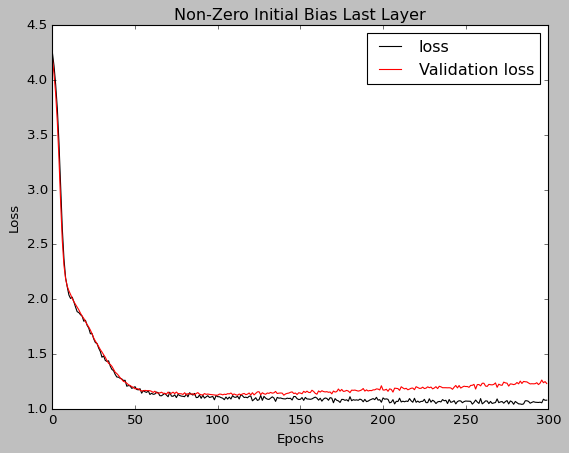

In [35]:
fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.plot(bm_history.history['loss'], '-', color='black',label='loss')
ax.plot(bm_history.history['val_loss'],'-',color='red' ,label ='Validation loss')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Non-Zero Initial Bias Last Layer')
fig.savefig(os.path.join(plot_loc, 'loss_300_epoch_{}_{}_{}_{}_{}.jpg'.format(nc_bin[0],
                                                                    nc_bin[1],
                                                                    nc_bin[2],
                                                                    nc_bin[3],
                                                                    nc_bin[4])))

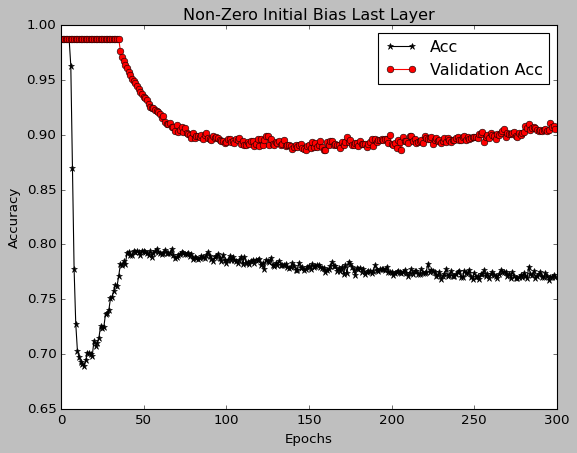

In [36]:
fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.plot(bm_history.history['accuracy'], '-*', color='black',label='Acc')
ax.plot(bm_history.history['val_accuracy'],'-o', color='red', label ='Validation Acc')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Non-Zero Initial Bias Last Layer')
fig.savefig(os.path.join(plot_loc, 'acc_300_epoch_{}_{}_{}_{}_{}.jpg'.format(nc_bin[0],
                                                                    nc_bin[1],
                                                                    nc_bin[2],
                                                                    nc_bin[3],
                                                                    nc_bin[4])))

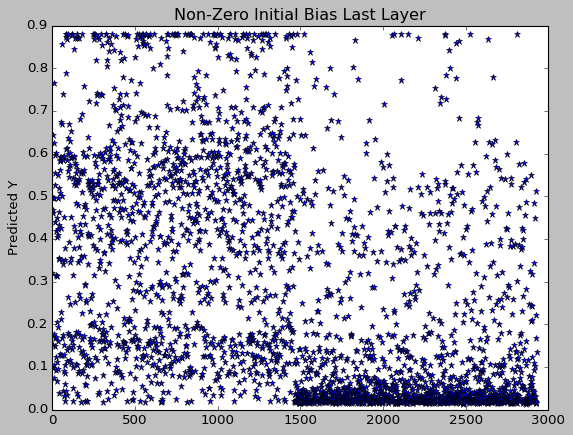

In [37]:
fig,ax = plt.subplots(1,1)
ax.plot(bm_model.predict(test_x[0,:]), '*')
plt.title('Non-Zero Initial Bias Last Layer')
plt.ylabel('Predicted Y')
fig.savefig(os.path.join(plot_loc, 'scatter_300_epooch_{}_{}_{}_{}_{}.jpg'.format(nc_bin[0],
                                                                    nc_bin[1],
                                                                    nc_bin[2],
                                                                    nc_bin[3],
                                                                    nc_bin[4])))

In [40]:
y_pred = bm_model.predict(test_x[0,:])

In [41]:
y_pred = bm_model.predict(test_x[0,:]) > 0.5
tf.math.confusion_matrix(test_y, y_pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1346,  119],
       [ 845,  620]], dtype=int32)>

# Looking at True negatives and False Postive

1) Use test y and sort out index to find TN and FP
2) Use test_x[1,:] to map back to test_dic
1) Sort index by 
what was found
2) Put index into 

In [ ]:
test_x[1,:10]